In [16]:
import os
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from datetime import datetime

## Load Data

In [3]:
ground_truth = {}
texts = {}

In [4]:
with open('train/gold_labels.json') as f:
    for line in f.readlines():
        gold_json = json.loads(line)
        ground_truth[gold_json['id']] = gold_json['label']

In [5]:
for file in os.listdir('train/txts'):
    with open('train/txts/' + file) as f:
        texts[file.split('.')[0]] = f.read()

In [6]:
empty = set(texts.keys()) - set(ground_truth.keys()) 
print(f'Delete {len(empty)} texts')
for idx in empty:
    texts.pop(idx)

Delete 17 texts


In [7]:
N = len(texts)
print(N)

3989


## Date

In [17]:
count_first = 0
count_in = 0
count_last = 0
count_max_year = 0

max_accuracy = 0
for left in range(10, 500, 10):
    for right in range (10, 500, 10):
        count_max_year = 0
        for idx, text in texts.items():
            if ground_truth[idx]['date'] in re.findall(r'\d\d\.\d\d\.\d\d\d\d', text):
                count_in += 1
            dates = re.findall(r'\d\d\.\d\d\.\d\d\d\d', text)
            if dates and ground_truth[idx]['date'] == dates[0]:
                count_first += 1
            if len(dates) > 1 and ground_truth[idx]['date'] == dates[-1]:
                count_last += 1

            gold_year = int(ground_truth[idx]['date'].split('.')[-1])
            years = re.findall(r'201\d', text[:left] + text[-right:])
            years = set(map(int, years))
            if years and max(years) == gold_year:
                count_max_year += 1
            accuracy = count_max_year/N
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                max_left = left
                max_right = right
        print(f'[{left}][{right}] count_max_year: ', count_max_year/N)
        
print(f'max_accuracy: {max_accuracy}, left: {max_left}, right: {max_right}')
print('count_in: ', count_in/N)
print('count_first: ', count_first/N)
print('count_last: ', count_last/N)
print('count_max_year: ', count_max_year/N)

[10][10] count_max_year:  0.007771371270995237
[10][20] count_max_year:  0.19628979694158938
[10][30] count_max_year:  0.2479318124843319
[10][40] count_max_year:  0.27224868388067186
[10][50] count_max_year:  0.2857859112559539
[10][60] count_max_year:  0.2895462521935322
[10][70] count_max_year:  0.28804211581850087
[10][80] count_max_year:  0.2915517673602407
[10][90] count_max_year:  0.29280521433943346
[10][100] count_max_year:  0.29230383554775635
[10][110] count_max_year:  0.29180245675607924


KeyboardInterrupt: 

In [97]:
print(ground_truth['e8c88af5854bc823efcbfc93e2988956abd381e9'])
print(texts['e8c88af5854bc823efcbfc93e2988956abd381e9'])

{'number': '293-ФЗ', 'name': 'О ратификации Соглашения между Правительством Российской Федерации и Правительством Японии об упрощении процедуры выдачи виз гражданам Российской Федерации и гражданам Японии', 'authority': 'Государственная Дума Федерального собрания Российской Федерации', 'date': '30.12.2012', 'type': 'федеральный закон'}
РОССИЙСКАЯ ФЕДЕРАЦИЯ
ФЕДЕРАЛЬНЫЙ ЗАКОН

О ратификации Соглашения между Правительством
Российской Федерации и Правительством Японии
об упрощении процедуры выдачи виз гражданам
Российской Федерации и гражданам Японии

Принят Государственной Думой 21 декабря 2012 года
Одобрен Советом Федерации 26 декабря 2012 года

Ратифицировать Соглашение между Правительством Российской
Федерации и Правительством Японии об упрощении процедуры выдачи виз
гражданам Российской Федерации и гражданам Японии, подписанное в

городе Токио 28 января 2012 года.

В.Путин

 

Москва, Кремль
30 декабря 2012 года
№ 293-ФЗ

ПНИ
2 100012 00113 7


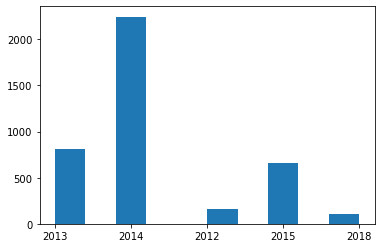

In [18]:
years = []
for label in ground_truth.values():
    years.append(label['date'].split('.')[-1])
plt.hist(years);

In [43]:
dates = []
for label in ground_truth.values():
    dates.append(datetime.strptime(label['date'], '%d.%m.%Y').date())
D = np.array(dates)
U, C = np.unique(D, return_counts=True)
c_max = np.argmax(C)
U[c_max]

datetime.date(2014, 12, 26)

In [166]:
month_mapping = {
    'января': '01',
    'февраля': '02',
    'марта': '03',
    'апреля': '04',
    'мая': '05',
    'июня': '06',
    'июля': '07',
    'августа': '08',
    'сентября': '09',
    'октября': '10',
    'ноября': '11',
    'декабря': '12',
}
year_true_count = 0
date_true_count = 0
date = None
for idx, text in texts.items():
    #print(idx)

    text = text.lower()
    search_text = text[:160] + text[-55:]
    
    # gold data
    gold_year = int(ground_truth[idx]['date'].split('.')[-1])
    gold_date = ground_truth[idx]['date']
    
    # max year
    years = re.findall(r'201\d', search_text)
    if not years:
        search_text = text
        years = re.findall(r'201\d', search_text)
    years = set(map(int, years))
    year = max(years)
    
    
    dates = re.findall(r'\d\d \w+ '+str(year), search_text)
    if dates:
        date = dates[-1]
        date = date.replace(' ', '.')
        for month, number in month_mapping.items():
            date = date.replace(month, number)
    else:
        dates = re.findall(r'\d\d\.\d\d\.'+str(year), search_text)
        if dates:
            date = dates[0]
        else:
            date = '26.12.2014'
    
    if date == gold_date:
        date_true_count += 1
    #if year == gold_year:
    #    year_true_count += 1

#print('Max years: ', year_true_count/N)
print('Date accuracy: ', date_true_count/N)

28.11.2013
24.12.2014
13.03.2014
26.04.2013
31.08.2015
25.12.2014
10.12.2014
29.10.2015
23.07.2013
19.11.2014
23.06.2014
25.11.2014
29.04.2015
19.03.2013
06.10.2014
12.11.2012
25.12.2012
12.06.2014
26.12.2014
30.12.2012
12.12.2014
12.03.2018
24.11.2014
17.12.2014
25.06.2015
27.06.2014
22.03.2014
06.03.2015
10.03.2015
21.11.2014
16.12.2014
23.05.2013
30.10.2013
30.05.2013
17.11.2014
24.06.2013
18.09.2014
15.08.2014
28.11.2014
23.12.2014
13.и.2014
15.12.2014
23.12.2015
22.01.2014
24.11.2014
30.04.2014
18.12.2015
21.12.2015
06.03.2015
01.09.2015
23.10.2014
25.10.2013
22.12.2014
16.12.2014
10.10.2014
27.03.2013
30.09.2013
27.11.2014
25.12.2014
30.10.2015
30.12.2014
26.04.2013
18.12.2014
26.12.2014
15.08.2014
28.11.2014
29.12.2014
19.11.2014
02.11.2015
11.02.2013
11.03.2015
11.03.2015
15.12.2015
18.12.2015
17.12.2015
29.06.2013
20.11.2014
10.10.2014
26.12.2014
21.06.2014
07.10.2014
25.07.2013
26.12.2014
10.12.2013
12.03.2015
11.12.2014
11.11.2014
11.01.2013
20.05.2014
21.12.2013
26.12.2014


16.10.2014
10.07.2014
25.11.2014
18.12.2014
26.12.2014
18.12.2014
17.01.2014
11.03.2015
26.09.2013
14.11.2014
30.09.2014
25.12.2014
21.12.2015
06.03.2018
14.12.2013
12.03.2013
11.07.2013
25.02.2014
13.01.2014
10.04.2013
10.11.2014
30.04.2013
24.12.2015
03.03.2015
13.11.2014
23.12.2015
30.09.2013
30.10.2015
26.12.2014
24.10.2013
15.01.2014
22.12.2014
22.11.2013
26.04.2013
06.07.2015
28.10.2014
24.12.2013
24.11.2014
26.11.2013
18.12.2014
07.03.2018
12.03.2015
12.03.2018
24.12.2014
08.12.2014
28.12.2013
17.04.2014
27.12.2014
31.10.2014
30.04.2015
18.11.2013
23.12.2014
23.07.2013
24.11.2014
26.12.2014
24.11.2014
10.07.2014
13.12.2012
24.12.2014
12.03.2015
26.11.2014
11.02.2014
26.08.2014
27.09.2014
03.12.2014
26.12.2014
30.10.2015
09.12.2014
18.09.2014
26.08.2013
14.11.2014
18.06.2012
26.12.2014
26.12.2014
22.10.2014
14.03.2018
24.11.2014
22.06.2013
10.09.2014
10.09.2014
14.11.2014
30.10.2015
18.12.2015
14.10.2012
19.08.2013
18.03.2013
20.10.2014
17.10.2014
23.12.2014
11.10.2014
22.10.2014

In [162]:
print(scores[22, 7])
print(np.arange(50, 500, 5)[22])
print(np.arange(20, 300, 5)[7])

0.9496114314364502
160
55


## CV

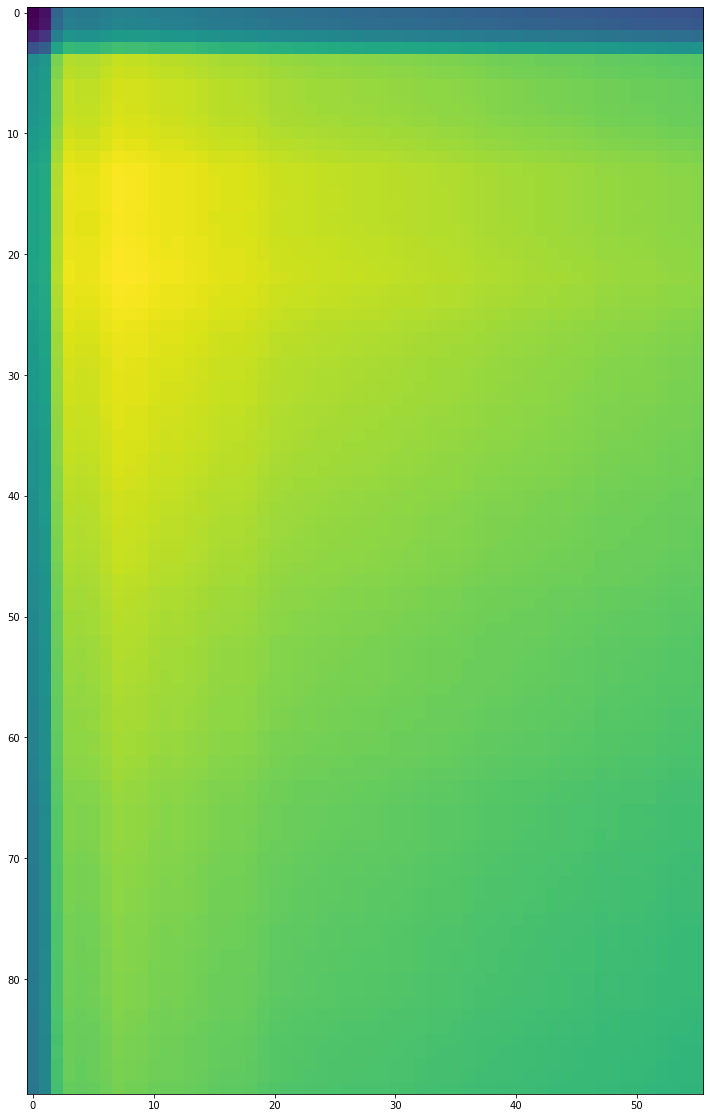

In [138]:
plt.figure(figsize=(20,20))
plt.imshow(scores)

In [132]:
month_mapping = {
    'января': '01',
    'февраля': '02',
    'марта': '03',
    'апреля': '04',
    'мая': '05',
    'июня': '06',
    'июля': '07',
    'августа': '08',
    'сентября': '09',
    'октября': '10',
    'ноября': '11',
    'декабря': '12',
}
iteration = 0
date_true_count = 0
date = None
range_left = range(50, 500, 5)
range_right = range(20, 300, 5)
scores = np.zeros((len(range_left), len(range_right)))
for i, left in enumerate(range_left):
    for j, right in enumerate(range_right):
        date_true_count = 0
        for idx, text in texts.items():
            #print(idx)

            text = text.lower()
            search_text = text[:left] + text[-right:]

            # gold data
            gold_year = int(ground_truth[idx]['date'].split('.')[-1])
            gold_date = ground_truth[idx]['date']

            # search max year
            years = re.findall(r'201\d', search_text)
            if not years:
                search_text = text
                years = re.findall(r'201\d', search_text)
            years = set(map(int, years))
            year = max(years)

            # search date
            dates = re.findall(r'\d\d \w+ '+str(year), search_text)
            if dates:
                date = dates[-1]
                date = date.replace(' ', '.')
                for month, number in month_mapping.items():
                    date = date.replace(month, number)
            else:
                dates = re.findall(r'\d\d\.\d\d\.'+str(year), search_text)
                if dates:
                    date = dates[0]
                else:
                    count += 1

            if date == gold_date:
                date_true_count += 1
    
        iteration += 1
        print('Progres: ', iteration/(len(range_left) * len(range_right)))
        scores[i, j] = date_true_count/N

Progres:  0.0001984126984126984
Progres:  0.0003968253968253968
Progres:  0.0005952380952380953
Progres:  0.0007936507936507937
Progres:  0.000992063492063492
Progres:  0.0011904761904761906
Progres:  0.001388888888888889
Progres:  0.0015873015873015873
Progres:  0.0017857142857142857
Progres:  0.001984126984126984
Progres:  0.0021825396825396826
Progres:  0.002380952380952381
Progres:  0.0025793650793650793
Progres:  0.002777777777777778
Progres:  0.002976190476190476
Progres:  0.0031746031746031746
Progres:  0.003373015873015873
Progres:  0.0035714285714285713
Progres:  0.00376984126984127
Progres:  0.003968253968253968
Progres:  0.004166666666666667
Progres:  0.004365079365079365
Progres:  0.004563492063492064
Progres:  0.004761904761904762
Progres:  0.00496031746031746
Progres:  0.005158730158730159
Progres:  0.005357142857142857
Progres:  0.005555555555555556
Progres:  0.005753968253968254
Progres:  0.005952380952380952
Progres:  0.006150793650793651
Progres:  0.006349206349206349

Progres:  0.05396825396825397
Progres:  0.05416666666666667
Progres:  0.054365079365079366
Progres:  0.054563492063492064
Progres:  0.05476190476190476
Progres:  0.05496031746031746
Progres:  0.05515873015873016
Progres:  0.055357142857142855
Progres:  0.05555555555555555
Progres:  0.05575396825396826
Progres:  0.055952380952380955
Progres:  0.05615079365079365
Progres:  0.05634920634920635
Progres:  0.05654761904761905
Progres:  0.056746031746031746
Progres:  0.05694444444444444
Progres:  0.05714285714285714
Progres:  0.05734126984126984
Progres:  0.057539682539682536
Progres:  0.05773809523809524
Progres:  0.05793650793650794
Progres:  0.05813492063492064
Progres:  0.058333333333333334
Progres:  0.05853174603174603
Progres:  0.05873015873015873
Progres:  0.05892857142857143
Progres:  0.059126984126984125
Progres:  0.05932539682539682
Progres:  0.05952380952380952
Progres:  0.059722222222222225
Progres:  0.05992063492063492
Progres:  0.06011904761904762
Progres:  0.06031746031746032
P

Progres:  0.10873015873015873
Progres:  0.10892857142857143
Progres:  0.10912698412698413
Progres:  0.10932539682539683
Progres:  0.10952380952380952
Progres:  0.10972222222222222
Progres:  0.10992063492063492
Progres:  0.11011904761904762
Progres:  0.11031746031746031
Progres:  0.11051587301587301
Progres:  0.11071428571428571
Progres:  0.11091269841269841
Progres:  0.1111111111111111
Progres:  0.1113095238095238
Progres:  0.11150793650793651
Progres:  0.11170634920634921
Progres:  0.11190476190476191
Progres:  0.11210317460317461
Progres:  0.1123015873015873
Progres:  0.1125
Progres:  0.1126984126984127
Progres:  0.1128968253968254
Progres:  0.1130952380952381
Progres:  0.1132936507936508
Progres:  0.11349206349206349
Progres:  0.11369047619047619
Progres:  0.11388888888888889
Progres:  0.11408730158730158
Progres:  0.11428571428571428
Progres:  0.11448412698412698
Progres:  0.11468253968253968
Progres:  0.11488095238095238
Progres:  0.11507936507936507
Progres:  0.11527777777777778


Progres:  0.1640873015873016
Progres:  0.16428571428571428
Progres:  0.16448412698412698
Progres:  0.16468253968253968
Progres:  0.16488095238095238
Progres:  0.16507936507936508
Progres:  0.16527777777777777
Progres:  0.16547619047619047
Progres:  0.16567460317460317
Progres:  0.16587301587301587
Progres:  0.16607142857142856
Progres:  0.16626984126984126
Progres:  0.16646825396825396
Progres:  0.16666666666666666
Progres:  0.16686507936507936
Progres:  0.16706349206349205
Progres:  0.16726190476190475
Progres:  0.16746031746031745
Progres:  0.16765873015873015
Progres:  0.16785714285714284
Progres:  0.16805555555555557
Progres:  0.16825396825396827
Progres:  0.16845238095238096
Progres:  0.16865079365079366
Progres:  0.16884920634920636
Progres:  0.16904761904761906
Progres:  0.16924603174603176
Progres:  0.16944444444444445
Progres:  0.16964285714285715
Progres:  0.16984126984126985
Progres:  0.17003968253968255
Progres:  0.17023809523809524
Progres:  0.17043650793650794
Progres:  0

Progres:  0.22003968253968254
Progres:  0.22023809523809523
Progres:  0.22043650793650793
Progres:  0.22063492063492063
Progres:  0.22083333333333333
Progres:  0.22103174603174602
Progres:  0.22123015873015872
Progres:  0.22142857142857142
Progres:  0.22162698412698412
Progres:  0.22182539682539681
Progres:  0.2220238095238095
Progres:  0.2222222222222222
Progres:  0.2224206349206349
Progres:  0.2226190476190476
Progres:  0.22281746031746033
Progres:  0.22301587301587303
Progres:  0.22321428571428573
Progres:  0.22341269841269842
Progres:  0.22361111111111112
Progres:  0.22380952380952382
Progres:  0.22400793650793652
Progres:  0.22420634920634921
Progres:  0.2244047619047619
Progres:  0.2246031746031746
Progres:  0.2248015873015873
Progres:  0.225
Progres:  0.2251984126984127
Progres:  0.2253968253968254
Progres:  0.2255952380952381
Progres:  0.2257936507936508
Progres:  0.2259920634920635
Progres:  0.2261904761904762
Progres:  0.2263888888888889
Progres:  0.2265873015873016
Progres: 

Progres:  0.2761904761904762
Progres:  0.2763888888888889
Progres:  0.2765873015873016
Progres:  0.2767857142857143
Progres:  0.276984126984127
Progres:  0.2771825396825397
Progres:  0.2773809523809524
Progres:  0.2775793650793651
Progres:  0.2777777777777778
Progres:  0.2779761904761905
Progres:  0.2781746031746032
Progres:  0.2783730158730159
Progres:  0.2785714285714286
Progres:  0.2787698412698413
Progres:  0.278968253968254
Progres:  0.2791666666666667
Progres:  0.27936507936507937
Progres:  0.27956349206349207
Progres:  0.27976190476190477
Progres:  0.27996031746031746
Progres:  0.28015873015873016
Progres:  0.28035714285714286
Progres:  0.28055555555555556
Progres:  0.28075396825396826
Progres:  0.28095238095238095
Progres:  0.28115079365079365
Progres:  0.28134920634920635
Progres:  0.28154761904761905
Progres:  0.28174603174603174
Progres:  0.28194444444444444
Progres:  0.28214285714285714
Progres:  0.28234126984126984
Progres:  0.28253968253968254
Progres:  0.2827380952380952

Progres:  0.33194444444444443
Progres:  0.33214285714285713
Progres:  0.3323412698412698
Progres:  0.3325396825396825
Progres:  0.3327380952380952
Progres:  0.3329365079365079
Progres:  0.3331349206349206
Progres:  0.3333333333333333
Progres:  0.333531746031746
Progres:  0.3337301587301587
Progres:  0.3339285714285714
Progres:  0.3341269841269841
Progres:  0.3343253968253968
Progres:  0.3345238095238095
Progres:  0.3347222222222222
Progres:  0.3349206349206349
Progres:  0.3351190476190476
Progres:  0.3353174603174603
Progres:  0.335515873015873
Progres:  0.3357142857142857
Progres:  0.3359126984126984
Progres:  0.33611111111111114
Progres:  0.33630952380952384
Progres:  0.33650793650793653
Progres:  0.33670634920634923
Progres:  0.33690476190476193
Progres:  0.3371031746031746
Progres:  0.3373015873015873
Progres:  0.3375
Progres:  0.3376984126984127
Progres:  0.3378968253968254
Progres:  0.3380952380952381
Progres:  0.3382936507936508
Progres:  0.3384920634920635
Progres:  0.338690476

Progres:  0.3880952380952381
Progres:  0.3882936507936508
Progres:  0.3884920634920635
Progres:  0.3886904761904762
Progres:  0.3888888888888889
Progres:  0.3890873015873016
Progres:  0.3892857142857143
Progres:  0.389484126984127
Progres:  0.3896825396825397
Progres:  0.3898809523809524
Progres:  0.3900793650793651
Progres:  0.3902777777777778
Progres:  0.3904761904761905
Progres:  0.3906746031746032
Progres:  0.39087301587301587
Progres:  0.39107142857142857
Progres:  0.39126984126984127
Progres:  0.39146825396825397
Progres:  0.39166666666666666
Progres:  0.39186507936507936
Progres:  0.39206349206349206
Progres:  0.39226190476190476
Progres:  0.39246031746031745
Progres:  0.39265873015873015
Progres:  0.39285714285714285
Progres:  0.39305555555555555
Progres:  0.39325396825396824
Progres:  0.39345238095238094
Progres:  0.39365079365079364
Progres:  0.39384920634920634
Progres:  0.39404761904761904
Progres:  0.39424603174603173
Progres:  0.39444444444444443
Progres:  0.3946428571428

Progres:  0.4446428571428571
Progres:  0.4448412698412698
Progres:  0.4450396825396825
Progres:  0.4452380952380952
Progres:  0.44543650793650796
Progres:  0.44563492063492066
Progres:  0.44583333333333336
Progres:  0.44603174603174606
Progres:  0.44623015873015875
Progres:  0.44642857142857145
Progres:  0.44662698412698415
Progres:  0.44682539682539685
Progres:  0.44702380952380955
Progres:  0.44722222222222224
Progres:  0.44742063492063494
Progres:  0.44761904761904764
Progres:  0.44781746031746034
Progres:  0.44801587301587303
Progres:  0.44821428571428573
Progres:  0.44841269841269843
Progres:  0.4486111111111111
Progres:  0.4488095238095238
Progres:  0.4490079365079365
Progres:  0.4492063492063492
Progres:  0.4494047619047619
Progres:  0.4496031746031746
Progres:  0.4498015873015873
Progres:  0.45
Progres:  0.4501984126984127
Progres:  0.4503968253968254
Progres:  0.4505952380952381
Progres:  0.4507936507936508
Progres:  0.4509920634920635
Progres:  0.4511904761904762
Progres:  0.

Progres:  0.5009920634920635
Progres:  0.5011904761904762
Progres:  0.5013888888888889
Progres:  0.5015873015873016
Progres:  0.5017857142857143
Progres:  0.501984126984127
Progres:  0.5021825396825397
Progres:  0.5023809523809524
Progres:  0.5025793650793651
Progres:  0.5027777777777778
Progres:  0.5029761904761905
Progres:  0.5031746031746032
Progres:  0.5033730158730159
Progres:  0.5035714285714286
Progres:  0.5037698412698413
Progres:  0.503968253968254
Progres:  0.5041666666666667
Progres:  0.5043650793650793
Progres:  0.504563492063492
Progres:  0.5047619047619047
Progres:  0.5049603174603174
Progres:  0.5051587301587301
Progres:  0.5053571428571428
Progres:  0.5055555555555555
Progres:  0.5057539682539682
Progres:  0.5059523809523809
Progres:  0.5061507936507936
Progres:  0.5063492063492063
Progres:  0.506547619047619
Progres:  0.5067460317460317
Progres:  0.5069444444444444
Progres:  0.5071428571428571
Progres:  0.5073412698412698
Progres:  0.5075396825396825
Progres:  0.507738

Progres:  0.5583333333333333
Progres:  0.558531746031746
Progres:  0.5587301587301587
Progres:  0.5589285714285714
Progres:  0.5591269841269841
Progres:  0.5593253968253968
Progres:  0.5595238095238095
Progres:  0.5597222222222222
Progres:  0.5599206349206349
Progres:  0.5601190476190476
Progres:  0.5603174603174603
Progres:  0.560515873015873
Progres:  0.5607142857142857
Progres:  0.5609126984126984
Progres:  0.5611111111111111
Progres:  0.5613095238095238
Progres:  0.5615079365079365
Progres:  0.5617063492063492
Progres:  0.5619047619047619
Progres:  0.5621031746031746
Progres:  0.5623015873015873
Progres:  0.5625
Progres:  0.5626984126984127
Progres:  0.5628968253968254
Progres:  0.5630952380952381
Progres:  0.5632936507936508
Progres:  0.5634920634920635
Progres:  0.5636904761904762
Progres:  0.5638888888888889
Progres:  0.5640873015873016
Progres:  0.5642857142857143
Progres:  0.564484126984127
Progres:  0.5646825396825397
Progres:  0.5648809523809524
Progres:  0.5650793650793651


Progres:  0.6150793650793651
Progres:  0.6152777777777778
Progres:  0.6154761904761905
Progres:  0.6156746031746032
Progres:  0.6158730158730159
Progres:  0.6160714285714286
Progres:  0.6162698412698413
Progres:  0.616468253968254
Progres:  0.6166666666666667
Progres:  0.6168650793650794
Progres:  0.6170634920634921
Progres:  0.6172619047619048
Progres:  0.6174603174603175
Progres:  0.6176587301587302
Progres:  0.6178571428571429
Progres:  0.6180555555555556
Progres:  0.6182539682539683
Progres:  0.618452380952381
Progres:  0.6186507936507937
Progres:  0.6188492063492064
Progres:  0.6190476190476191
Progres:  0.6192460317460318
Progres:  0.6194444444444445
Progres:  0.6196428571428572
Progres:  0.6198412698412699
Progres:  0.6200396825396826
Progres:  0.6202380952380953
Progres:  0.620436507936508
Progres:  0.6206349206349207
Progres:  0.6208333333333333
Progres:  0.621031746031746
Progres:  0.6212301587301587
Progres:  0.6214285714285714
Progres:  0.6216269841269841
Progres:  0.621825

Progres:  0.6718253968253968
Progres:  0.6720238095238096
Progres:  0.6722222222222223
Progres:  0.672420634920635
Progres:  0.6726190476190477
Progres:  0.6728174603174604
Progres:  0.6730158730158731
Progres:  0.6732142857142858
Progres:  0.6734126984126985
Progres:  0.6736111111111112
Progres:  0.6738095238095239
Progres:  0.6740079365079366
Progres:  0.6742063492063493
Progres:  0.674404761904762
Progres:  0.6746031746031746
Progres:  0.6748015873015873
Progres:  0.675
Progres:  0.6751984126984127
Progres:  0.6753968253968254
Progres:  0.6755952380952381
Progres:  0.6757936507936508
Progres:  0.6759920634920635
Progres:  0.6761904761904762
Progres:  0.6763888888888889
Progres:  0.6765873015873016
Progres:  0.6767857142857143
Progres:  0.676984126984127
Progres:  0.6771825396825397
Progres:  0.6773809523809524
Progres:  0.6775793650793651
Progres:  0.6777777777777778
Progres:  0.6779761904761905
Progres:  0.6781746031746032
Progres:  0.6783730158730159
Progres:  0.6785714285714286
P

Progres:  0.7289682539682539
Progres:  0.7291666666666666
Progres:  0.7293650793650793
Progres:  0.729563492063492
Progres:  0.7297619047619047
Progres:  0.7299603174603174
Progres:  0.7301587301587301
Progres:  0.7303571428571428
Progres:  0.7305555555555555
Progres:  0.7307539682539682
Progres:  0.7309523809523809
Progres:  0.7311507936507936
Progres:  0.7313492063492063
Progres:  0.731547619047619
Progres:  0.7317460317460317
Progres:  0.7319444444444444
Progres:  0.7321428571428571
Progres:  0.7323412698412698
Progres:  0.7325396825396825
Progres:  0.7327380952380952
Progres:  0.7329365079365079
Progres:  0.7331349206349206
Progres:  0.7333333333333333
Progres:  0.733531746031746
Progres:  0.7337301587301587
Progres:  0.7339285714285714
Progres:  0.7341269841269841
Progres:  0.7343253968253968
Progres:  0.7345238095238096
Progres:  0.7347222222222223
Progres:  0.734920634920635
Progres:  0.7351190476190477
Progres:  0.7353174603174604
Progres:  0.7355158730158731
Progres:  0.735714

Progres:  0.7859126984126984
Progres:  0.7861111111111111
Progres:  0.7863095238095238
Progres:  0.7865079365079365
Progres:  0.7867063492063492
Progres:  0.7869047619047619
Progres:  0.7871031746031746
Progres:  0.7873015873015873
Progres:  0.7875
Progres:  0.7876984126984127
Progres:  0.7878968253968254
Progres:  0.7880952380952381
Progres:  0.7882936507936508
Progres:  0.7884920634920635
Progres:  0.7886904761904762
Progres:  0.7888888888888889
Progres:  0.7890873015873016
Progres:  0.7892857142857143
Progres:  0.789484126984127
Progres:  0.7896825396825397
Progres:  0.7898809523809524
Progres:  0.790079365079365
Progres:  0.7902777777777777
Progres:  0.7904761904761904
Progres:  0.7906746031746031
Progres:  0.7908730158730158
Progres:  0.7910714285714285
Progres:  0.7912698412698412
Progres:  0.7914682539682539
Progres:  0.7916666666666666
Progres:  0.7918650793650793
Progres:  0.792063492063492
Progres:  0.7922619047619047
Progres:  0.7924603174603174
Progres:  0.7926587301587301


Progres:  0.8426587301587302
Progres:  0.8428571428571429
Progres:  0.8430555555555556
Progres:  0.8432539682539683
Progres:  0.843452380952381
Progres:  0.8436507936507937
Progres:  0.8438492063492063
Progres:  0.844047619047619
Progres:  0.8442460317460317
Progres:  0.8444444444444444
Progres:  0.8446428571428571
Progres:  0.8448412698412698
Progres:  0.8450396825396825
Progres:  0.8452380952380952
Progres:  0.8454365079365079
Progres:  0.8456349206349206
Progres:  0.8458333333333333
Progres:  0.846031746031746
Progres:  0.8462301587301587
Progres:  0.8464285714285714
Progres:  0.8466269841269841
Progres:  0.8468253968253968
Progres:  0.8470238095238095
Progres:  0.8472222222222222
Progres:  0.8474206349206349
Progres:  0.8476190476190476
Progres:  0.8478174603174603
Progres:  0.848015873015873
Progres:  0.8482142857142857
Progres:  0.8484126984126984
Progres:  0.8486111111111111
Progres:  0.8488095238095238
Progres:  0.8490079365079365
Progres:  0.8492063492063492
Progres:  0.849404

Progres:  0.8998015873015873
Progres:  0.9
Progres:  0.9001984126984127
Progres:  0.9003968253968254
Progres:  0.9005952380952381
Progres:  0.9007936507936508
Progres:  0.9009920634920635
Progres:  0.9011904761904762
Progres:  0.9013888888888889
Progres:  0.9015873015873016
Progres:  0.9017857142857143
Progres:  0.901984126984127
Progres:  0.9021825396825397
Progres:  0.9023809523809524
Progres:  0.9025793650793651
Progres:  0.9027777777777778
Progres:  0.9029761904761905
Progres:  0.9031746031746032
Progres:  0.9033730158730159
Progres:  0.9035714285714286
Progres:  0.9037698412698413
Progres:  0.903968253968254
Progres:  0.9041666666666667
Progres:  0.9043650793650794
Progres:  0.9045634920634921
Progres:  0.9047619047619048
Progres:  0.9049603174603175
Progres:  0.9051587301587302
Progres:  0.9053571428571429
Progres:  0.9055555555555556
Progres:  0.9057539682539683
Progres:  0.905952380952381
Progres:  0.9061507936507937
Progres:  0.9063492063492063
Progres:  0.906547619047619
Prog

Progres:  0.9571428571428572
Progres:  0.9573412698412699
Progres:  0.9575396825396826
Progres:  0.9577380952380953
Progres:  0.957936507936508
Progres:  0.9581349206349207
Progres:  0.9583333333333334
Progres:  0.9585317460317461
Progres:  0.9587301587301588
Progres:  0.9589285714285715
Progres:  0.9591269841269842
Progres:  0.9593253968253969
Progres:  0.9595238095238096
Progres:  0.9597222222222223
Progres:  0.959920634920635
Progres:  0.9601190476190476
Progres:  0.9603174603174603
Progres:  0.960515873015873
Progres:  0.9607142857142857
Progres:  0.9609126984126984
Progres:  0.9611111111111111
Progres:  0.9613095238095238
Progres:  0.9615079365079365
Progres:  0.9617063492063492
Progres:  0.9619047619047619
Progres:  0.9621031746031746
Progres:  0.9623015873015873
Progres:  0.9625
Progres:  0.9626984126984127
Progres:  0.9628968253968254
Progres:  0.9630952380952381
Progres:  0.9632936507936508
Progres:  0.9634920634920635
Progres:  0.9636904761904762
Progres:  0.9638888888888889
